# Data Vizualization

In this notebook, we analyze the results obtained by our data corruption experiment from `FinalExperiments.ipynb`. In short, we ran data corruption over 4 different datasets:

- Synthetic
  1. [Linearly Separable](#syn-lin)
  2. [Non-Linearly Separable](#syn-non)

- Non-Synthetic
  1. [Linearly Separable (Iris Dataset)](#real-lin)
  2. [Non-Linearly Separable (Skin/No Skin Dataset)](#real-non)
  
We split the analysis of these datasets according to the above structure and create 3 plots:


|  Synthetic Separable | Synthetic Non-Separable | Iris (Separable) | Skin/No Skin (Non-Separable) |
| :------------------: | :---------------------: | :--------------: | :--------------------------: |
| [Plot Line](#syn-lin-plot) | [Plot Line](#syn-non-plot) | [Plot Line](#iris-lin-plot) | [Plot Line](#skin-non-plot) |
| [Box Plot](#syn-lin-box)   | [Box Plot](#syn-non-box)   | [Box Plot](#iris-lin-box) | [Box Plot](#skin-non-box) |
| [Table of Affordance](#syn-lin-table) | [Table of Affordance](#syn-non-table) | [Table of Affordance](#iris-lin-table) | [Table of Affordance](#skin-non-table) |


In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

In [111]:
def pocket_complexity(
    epsilon:      float, 
    epsilon_knot: float, 
    delta:        float, 
    p:            int,
    L:            float,
    ):
    """
    epsilon:      Actual Error of network
    epsilon_knot: Measured error on training set of E
    delta:        Probability
    p:            Number of input neurons
    L:            Length of the weight vector.
    """
    a = np.math.log(8/delta)
    s = (epsilon - epsilon_knot)/epsilon
    b_min = min(2*(p+1), 4*(p+1)*np.math.log10(np.math.e))
    c = max(a, b_min * np.math.log(16/(s**2 * epsilon)))
    A = np.math.ceil((8 / (s**2 * epsilon)) * c)
    
    x = (np.math.log(1/delta) + (p+1)*np.math.log(2*L+1)) / (s**2 * epsilon)
    B = x * min(1/(2*epsilon), 2)
    return np.math.ceil(min(A, B))

def epsilon_lower_bound(n_data, vc_dim, delta):
    """ Return epsilon for given sample size
    
    """
    return (1/n_data) * (vc_dim + np.math.log(1/delta))


def epsilon_PAC_complexity(
    total_data, 
    total_buckets, 
    vc_dim, 
    delta
    ):
    
    # To contain score per # of datapoints
    pac_analysis = {f'score': [], 'buckets': []}

    data_per_buckets = total_data / total_buckets
    # Dictionary of # of data for given # of buckets
    buckets_to_n_data = {buckets: data_per_buckets * buckets for buckets in range(1, total_buckets+1)}
    
    # Populate dictionary of values. Storing size S and obtained epsilon
    for buckets, data_points in buckets_to_n_data.items():
        epsilon_complexity       = 1 - epsilon_lower_bound(data_points, vc_dim, delta)
        pac_analysis[f'score'].append(epsilon_complexity)
        pac_analysis['buckets'].append(100 - buckets)
        
    return pd.DataFrame(pac_analysis)


def epsilon_pocket_complexity(
    total_data, 
    total_buckets, 
    epsilon_knot, 
    delta, 
    vc_dim, 
    L
    ):
    """"""
    # vc-dim - 1 == p
    
    # To contain score per # of datapoints
    pac_analysis = {f'score': [], 'buckets': []}
    
    # Will create dictionary of epsilon given some number of samples 
    epsilon_samples = np.linspace(0.05, 0.99999, 10_000_000) # Used in sampling for sample complexity.
    samples_to_epsilon = { pocket_complexity(epsilon=epsilon, epsilon_knot=epsilon_knot, delta=delta, p=vc_dim - 1, L=L): epsilon for epsilon in epsilon_samples }
    data_per_buckets = total_data // total_buckets
    # Dictionary of # of data for given # of buckets
    buckets_to_n_data = {buckets: data_per_buckets * buckets for buckets in range(1, total_buckets+1)}
    
    debug_counter = 0
    for buckets, n_data in buckets_to_n_data.items():
        debug_counter += 1
        try:
            epsilon_complexity = 1 - samples_to_epsilon[n_data]
        except KeyError:
            total_debug_counter = 0
            for buckets, n_data in buckets_to_n_data.items():
                total_debug_counter += 1
            #import pdb; pdb.set_trace()
            if n_data < 100:
                # Samples used too small. 
                epsilon_complexity = np.NaN
            else:
                # Sample asked for probably too large!
                epsilon_complexity = np.NaN
            
        pac_analysis[f'score'].append(epsilon_complexity)
        pac_analysis['buckets'].append(100 - buckets)
        
    return pd.DataFrame(pac_analysis)


In [3]:
from glob import glob
import re
from collections import defaultdict

def extract_and_combine(file: str, combine: bool=False):
    '''Collect and combine data
    
    params
    ======
    
    file:
        File name with wild (*) to search for.
    combine:
        Flag for whether returning combined dataframe of history.
    '''
    
    data = {} # Experiment -> results
    
    # Convert file wildcard into valid RegEx wildcard
    pattern = file.replace('*', '(.*)')

    # Collect every pickle file and load into data dictionary
    for f in glob(file):
        match = re.search(pattern, f)
        experiment = match.group(1).strip()
        with open(f, 'rb') as jar:
            data[experiment] = pickle.load(jar)
    
    # Combines the data into a singlue dictionary.
    if combine:
        combined_history =  defaultdict(list)
        for exp_num, _dict in data.items():
            for key, value in _dict['history'].items():
                combined_history[key].append(value[0])
            
        #history_frames = [pd.DataFrame(_dict['history']) for _dict in list(data.values())]
        return data, combined_history
    else:
        return data

### A Note on Seaborn Plotting

This is a personal note, and not required to be read if you understand seaborn (which I dont!)

#### Seaborn data plotting structure

Unlike Matplotlib, seaborn will only plot the data using the provided columns. In Matplotlib, it is possible to make plots just with a dictionary where the data can be categorized based on the columns. Further, we can use multiple datasets when passing them to matplotlib and perform the plotting. In seaborn, it seems like the data has to be all in one table/dictionary. Thus, to achieve a similar result as in matplotlib passing multiple datasets at once, we have to merge the datasets and create a _new column_ that will distinguish among the datasets:

Data 1:

| A | B | C |
| :---: | :---: | :---: |
| ... | ... | ... |
| ... | ... | ... |
| ... | ... | ... |

Data 2:

| A | B | C |
| :---: | :---: | :---: |
| ;;; | ;;; | ;;; |
| ;;; | ;;; | ;;; |
| ;;; | ;;; | ;;; |

Structure of data for seaborn to plot (as in ploting both as separate datasets categorically)

| A | B | C | Dataset |
| :---: | :---: | :---: | :---: |
| ... | ... | ... | 1 | 
| ... | ... | ... | 1 |
| ;;; | ;;; | ;;; | 2 |
| ;;; | ;;; | ;;; | 2 |



## Synthetic Linear
<a id="syn-lin"></a>

with open('extra/results/syn-lin_0_results.pkl', 'rb') as pkl:
    lin_pkl = pickle.load(pkl)

In [64]:
data, history_lin = extract_and_combine(file='results/syn-lin_4d-*_results.pkl', combine=True)
lin_pkl = data[list(data.keys())[0]] # For ease of information

#history_lin = lin_pkl['history']

# Make into sns format
# Linear Results
lin_data = {'score': [], 'buckets': [], 'n_run': []}
for n_buckets, scores in history_lin.items():
    if n_buckets == 'L': # Ignore weight vector distance for plots
        continue
    for n_run, score in enumerate(scores):
        lin_data['score'].append(score)
        lin_data['buckets'].append(100 - n_buckets)
        lin_data['n_run'].append(n_run)
        

## Synthetic Non Linear
<a id="syn-non"></a>

In [135]:
data, history_non_lin = extract_and_combine(file='results/syn-non_4d-*_results.pkl', combine=True)
non_lin_pkl = data[list(data.keys())[0]] # For ease of information
#history_non_lin = non_lin_pkl['history']

# Non Linear Results
non_lin_data = {'score': [], 'buckets': [], 'n_run': []}
for n_buckets, scores in history_non_lin.items():
    if n_buckets == 'L': # Ignore weight vector distance for plots
        continue
    for n_run, score in enumerate(scores):
        non_lin_data['score'].append(score)
        non_lin_data['buckets'].append(100 - n_buckets)
        non_lin_data['n_run'].append(n_run)
        

## Iris Dataset (Linear)
<a id="real-lin"></a>

In [180]:
#history_iris = iris_pkl['history']
data, history_iris = extract_and_combine(file='results/iris_*_results.pkl', combine=True)
iris_pkl = data[list(data.keys())[0]] # For ease of information

# Iris Results
iris_data = {'score': [], 'buckets': [], 'n_run': []}
for n_buckets, scores in history_iris.items():
    if n_buckets == 'L': # Ignore weight vector distance for plots
        continue
    for n_run, score in enumerate(scores):
        iris_data['score'].append(score)
        iris_data['buckets'].append(80 - n_buckets)
        iris_data['n_run'].append(n_run)
        

In [53]:
len(data)

100

## Skin Dataset (Non Linear)
<a id="real-non"></a>

with open('pickles/skin_results.pkl', 'rb') as pkl:
    skin_pkl = pickle.load(pkl)

In [59]:
skin_data['score']

[0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.20833333333333334,
 0.2083333

In [265]:
data, history_skin = extract_and_combine(file='results/skin_3000-*_results.pkl', combine=True)
skin_pkl = data[list(data.keys())[0]] # For ease of information


# Skin/No Skin Results
skin_data = {'score': [], 'corruption': [], 'n_run': []}
for n_buckets, scores in history_skin.items():
    if n_buckets == 'L': # Ignore weight vector distance for plots
        continue
    for n_run, score in enumerate(scores):
        skin_data['score'].append(score)
        skin_data['corruption'].append(100 - n_buckets)
        skin_data['n_run'].append(n_run)
        

In [266]:
len(history_skin)

101

# Line Plots

In [65]:
# Plot Configuration
height = 4
aspect = 12/7

### Synthetic Datasets

#### Synthetic Linearly-Separable
<a id="syn-lin-plot"></a>

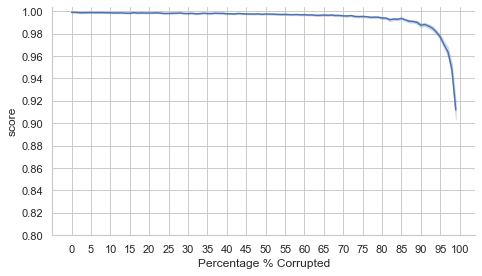

In [67]:
ax = sns.relplot(data=lin_data, kind='line', x='buckets', y='score', height=height, aspect=aspect)
# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Linearly-Separable)')
# Since the lowest number of buckets used is 1, I add it directly bc range will not allow it
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
plt.yticks(np.linspace(0.8, 1., 11))
plt.xlabel("Percentage % Corrupted")
#ax.set(title='Score vs Buckets Used')
#plt.show()
ax.figure.savefig('lin_percent.png', dpi=200)

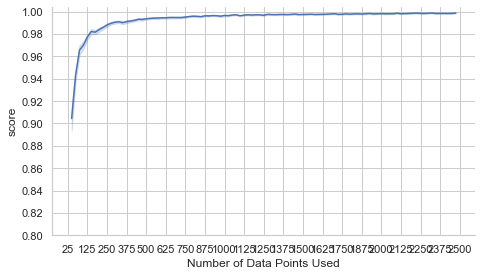

In [46]:
ax = sns.relplot(data=lin_data, kind='line', x='buckets', y='score', height=height, aspect=aspect)

# Figure Attributes (using pyplot)
n_data = int(2_500/100) # Used for showing how many data points were used.

#plt.title('Score vs Buckets Used (Synthetic Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[1*n_data] + [percentage*n_data for percentage in range(5, 101, 5)]
)
plt.yticks(np.linspace(0.8, 1., 11))
plt.xlabel("Number of Data Points Used")
#ax.set(title='Score vs Buckets Used')
#plt.show()
ax.figure.savefig('lin_points.png', dpi=2lower00)

##### PAC Bounds

In [112]:
'''PAC Bounds according to P.M. Long on Half-spaces'''
# Calculate Epsilon Lower Bounds
total_data    = lin_pkl['n_data'] - 600
total_buckets = lin_pkl['n_buckets']
vc_dim        = lin_pkl['n_attribs'] + 1 # Radon's Theorem
delta         = 0.01

epsilon_PAC = epsilon_PAC_complexity(total_data=total_data, total_buckets=total_buckets, vc_dim=vc_dim, delta=delta)
    
# Create matching data frame that could be concatenated with data to produce seaborn plot
epsilon_PAC = epsilon_PAC.assign(n_run=-1, dataset='Long (Halfspaces) Bound') 
epsilon_PAC['score'] = epsilon_PAC.score.map(lambda x: x if x > 0. else np.NaN) # Mask invalid (negative) values


'''Gallant Bounds on Pocket Perceptron'''
# Dataset parameters
total_data    = lin_pkl['n_data'] - 600
total_buckets = lin_pkl['n_buckets']
# Calculate epsilon knot
lin_dataframe= pd.DataFrame(history_lin).drop('L', axis=1)
epsilon_knot  = 1 - lin_dataframe.mean().mean()
#epsilon_knot  = 0.01
vc_dim        = lin_pkl['n_attribs'] + 1 # Radon's Theorem
delta         = 0.01
L             = pd.DataFrame(history_lin['L']).max().max()
# vc_dim = 10 # Gallant's paper comparison of results
epsilon_pocket = epsilon_pocket_complexity(total_data=total_data, total_buckets=total_buckets, epsilon_knot=epsilon_knot, delta=delta, vc_dim=vc_dim, L=L)
    
# Make data match results from experiments' parameters
epsilon_pocket = epsilon_pocket.assign(n_run=-1, dataset='Pocket Gallant Bound')
#epsilon_pocket = epsilon_pocket[lin_pocket_err.buckets < n_buckets] # Set limit of n samples. (Else, we get up to ~50,000)


# Creates new columns dataset to identify between scores from actual results and PAC analysis
pre_concat = [
    pd.DataFrame(lin_data).assign(dataset='Mean Accuracy'), 
    epsilon_PAC,
    epsilon_pocket
]

# Final data table
lin_and_bounds = pd.concat(pre_concat).reset_index(drop=True)




In [113]:
lin_pkl['n_attribs']


5

In [147]:
# Plot Configuration
height = 4
aspect = 12/6

In [282]:
tmp = lin_and_bounds

In [283]:
tmp.drop(lin_and_bounds[lin_and_bounds.dataset=='Long (Halfspaces) Bound'].index, inplace=True)

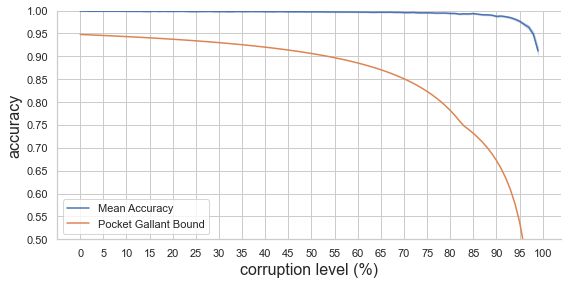

In [284]:
#sns.relplot(data=lin_and_pac, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)

ax = sns.relplot(data=tmp, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)
ax._legend.remove()
# Figure Attributes (using pyplot)
n_data = int(lin_pkl['n_data']/100) # Used for showing how many data points were used.

#plt.title('Score vs Buckets Used (Synthetic Linearly-Separable)')
plt.legend(loc='lower left')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
scr_min, scr_max = 0.5, 1.
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
plt.xlabel("corruption level (%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
#plt.title("Synthetic Linearly-Separable", fontsize=16)
#ax.set(title='Score vs Buckets Used')
#plt.show()
ax.figure.savefig('FinalResults/lin_bounds_dimension_4.png', dpi=200)

#### Synthetic Linearly-Non Separable
<a id="syn-non-plot"></a>

In [124]:
# Plot Configuration
height = 4
aspect = 12/7

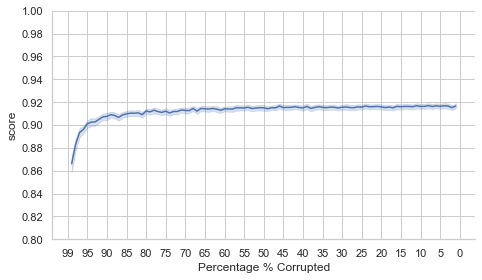

In [125]:
ax = sns.relplot(data=non_lin_data, kind='line', x='buckets', y='score', height=height, aspect=aspect)

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Synthetic Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[99] + [percentage for percentage in range(95, -1, -5)]
)
plt.xlabel("Percentage % Corrupted")
scr_min, scr_max = 0.8, 1.
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
ax.figure.savefig('non_percent.png', dpi=600)
#plt.show()

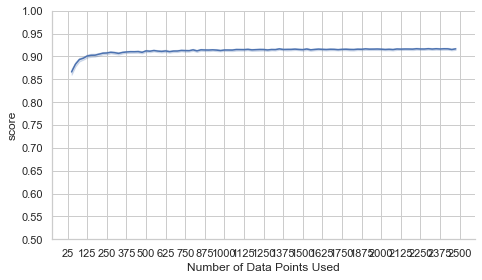

In [51]:
ax = sns.relplot(data=non_lin_data, kind='line', x='buckets', y='score', height=height, aspect=aspect)

# Figure Attributes (using pyplot)
n_data = int(non_lin_pkl['n_data']/100) # Used for showing how many data points were used.

#plt.title('Score vs Buckets Used (Synthetic Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[1*n_data] + [percentage*n_data for percentage in range(5, 101, 5)]
)
scr_min, scr_max = 0.8, 1.
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
plt.xlabel("Number of Data Points Used")
#ax.set(title='Score vs Buckets Used')
ax.figure.savefig('non_points.png', dpi=600)
#plt.show()

##### PAC Bounds

In [134]:
len(history_non_lin[99])

600

In [136]:
'''PAC Bounds according to P.M. Long on Half-spaces'''
# Calculate Epsilon Lower Bounds
total_data    = non_lin_pkl['n_data'] - 600
total_buckets = non_lin_pkl['n_buckets']
vc_dim        = non_lin_pkl['n_attribs'] + 1 # Radon's Theorem
delta         = 0.01

epsilon_PAC = epsilon_PAC_complexity(total_data=total_data, total_buckets=total_buckets, vc_dim=vc_dim, delta=delta)
    
# Create matching data frame that could be concatenated with data to produce seaborn plot
epsilon_PAC = epsilon_PAC.assign(n_run=-1, dataset='Long (Halfspaces) Bound') 
epsilon_PAC['score'] = epsilon_PAC.score.map(lambda x: x if x > 0. else np.NaN) # Mask invalid (negative) values


'''Gallant Bounds on Pocket Perceptron'''
# Dataset parameters
total_data    = non_lin_pkl['n_data'] - 600
total_buckets = non_lin_pkl['n_buckets']
# Calculate epsilon knot
non_lin_dataframe= pd.DataFrame(history_non_lin).drop('L', axis=1)
epsilon_knot  = 1 - non_lin_dataframe.mean().mean()
#epsilon_knot  = 0.05
vc_dim        = non_lin_pkl['n_attribs'] + 1 # Radon's Theorem
delta         = 0.05
L             = pd.DataFrame(history_non_lin['L']).max().max()
# vc_dim = 10 # Gallant's paper comparison of results
epsilon_pocket = epsilon_pocket_complexity(total_data=total_data, total_buckets=total_buckets, epsilon_knot=epsilon_knot, delta=delta, vc_dim=vc_dim, L=L)
    
# Make data match results from experiments' parameters
epsilon_pocket = epsilon_pocket.assign(n_run=-1, dataset='Gallant Bound')
#epsilon_pocket = epsilon_pocket[lin_pocket_err.buckets < n_buckets] # Set limit of n samples. (Else, we get up to ~50,000)


# Creates new columns dataset to identify between scores from actual results and PAC analysis
pre_concat = [
    pd.DataFrame(non_lin_data).assign(dataset='Mean Accuracy'), 
    epsilon_PAC,
    epsilon_pocket
]

# Final data table
non_lin_and_bounds = pd.concat(pre_concat).reset_index(drop=True)




In [278]:
# Plot Configuration
height = 4
aspect = 12/6

In [279]:
tmp = non_lin_and_bounds

In [280]:
tmp.drop(non_lin_and_bounds[non_lin_and_bounds.dataset=='Long (Halfspaces) Bound'].index, inplace=True)

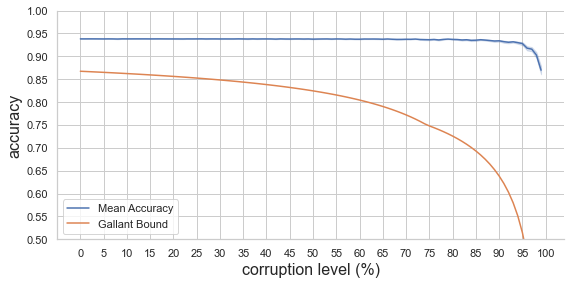

In [281]:
#sns.relplot(data=lin_and_pac, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)

ax = sns.relplot(data=tmp, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)
ax._legend.remove()
# Figure Attributes (using pyplot)
n_data = int(non_lin_pkl['n_data']/100) # Used for showing how many data points were used.

#plt.title('Score vs Buckets Used (Synthetic Non Linearly-Separable)')
plt.legend(loc='lower left')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
scr_min, scr_max = 0.5, 1.
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))

plt.xlabel("corruption level (%)", fontsize=16)
#plt.title("Synthetic Non Linearly-Separable")
plt.ylabel('accuracy', fontsize=16)
#ax.set(title='Score vs Buckets Used')
ax.figure.savefig('FinalResults/non_bounds_dimension_4.png', dpi=200)
#plt.show()

### Real Datasets

#### Iris Data (Linearly-Separable)
<a id="iris-lin-plot"></a>

In [173]:
# Plot Configuration
height = 4
aspect = 12/7

In [177]:
iris_data

{'score': [0.9333333333333333,
  0.6666666666666666,
  0.3333333333333333,
  0.6666666666666666,
  1.0,
  0.4666666666666667,
  0.6666666666666666,
  0.6666666666666666,
  1.0,
  0.9,
  1.0,
  0.3333333333333333,
  0.9666666666666667,
  0.9333333333333333,
  1.0,
  1.0,
  0.9666666666666667,
  0.3333333333333333,
  1.0,
  1.0,
  1.0,
  0.6666666666666666,
  1.0,
  0.6666666666666666,
  0.6666666666666666,
  1.0,
  0.6666666666666666,
  1.0,
  1.0,
  0.6666666666666666,
  1.0,
  0.9,
  0.6666666666666666,
  0.9,
  0.6666666666666666,
  1.0,
  0.3333333333333333,
  1.0,
  1.0,
  0.3333333333333333,
  0.7333333333333333,
  1.0,
  0.8333333333333334,
  1.0,
  0.6666666666666666,
  0.3333333333333333,
  1.0,
  0.6666666666666666,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.6666666666666666,
  1.0,
  0.6666666666666666,
  0.3333333333333333,
  0.6666666666666666,
  1.0,
  0.6666666666666666,
  0.3333333333333333,
  0.9,
  0.6666666666666666,
  0.6666666666666666,
  

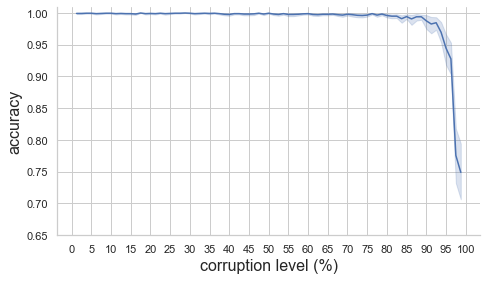

In [207]:
ax = sns.relplot(data=iris_data, kind='line', x='buckets', y='score', height=height, aspect=aspect)

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Iris Dataset | Linearly-Separable)')
plt.xticks(
    ticks=range(0, 81, 4), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
plt.xlabel("corruption level (%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
scr_min, scr_max = 0.65, 1.0
plt.ylim(scr_min, 1.01)
plt.yticks(np.linspace(scr_min, scr_max, 8))
ax.figure.savefig('iris_percent.png', dpi=200)
#plt.show()

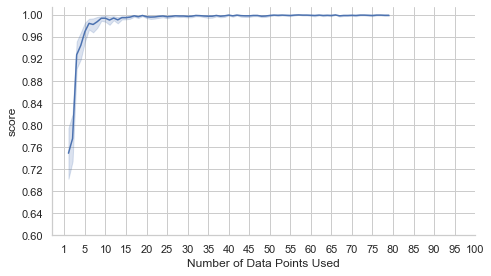

In [37]:
ax = sns.relplot(data=iris_data, kind='line', x='buckets', y='score', height=height, aspect=aspect)

# Figure Attributes (using pyplot)
n_data = int(iris_pkl['n_data']/100) # Used for showing how many data points were used.

#plt.title('Score vs Buckets Used (Iris Dataset | Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[1*n_data] + [percentage*n_data for percentage in range(5, 101, 5)]
)
plt.yticks(np.linspace(0.6, 1., 11))
plt.xlabel("Number of Data Points Used")
#ax.set(title='Score vs Buckets Used')
ax.figure.savefig('iris_points.png', dpi=200)
#plt.show()

##### PAC Bounds

In [38]:
'''PAC Bounds according to P.M. Long on Half-spaces'''
# Calculate Epsilon Lower Bounds
total_data    = iris_pkl['n_data']
total_buckets = iris_pkl['n_buckets']
vc_dim        = iris_pkl['n_attribs'] + 1 # Radon's Theorem
delta         = 0.01

epsilon_PAC = epsilon_PAC_complexity(total_data=total_data, total_buckets=total_buckets, vc_dim=vc_dim, delta=delta)
    
# Create matching data frame that could be concatenated with data to produce seaborn plot
epsilon_PAC = epsilon_PAC.assign(n_run=-1, dataset='Long (Halfspaces) Bound') 
epsilon_PAC['score'] = epsilon_PAC.score.map(lambda x: x if x > 0. else np.NaN) # Mask invalid (negative) values

'''Gallant Bounds on Pocket Perceptron'''
# Dataset parameters
total_data    = iris_pkl['n_data'] 
total_buckets = iris_pkl['n_buckets']
# Calculate epsilon knot
iris_dataframe= pd.DataFrame(history_iris).drop('L', axis=1)
epsilon_knot  = 1 - iris_dataframe.mean().mean()
#epsilon_knot  = 0.05
vc_dim        = iris_pkl['n_attribs'] + 1 # Radon's Theorem
delta         = 0.05
L             = pd.DataFrame(history_iris['L']).max().max()
# vc_dim = 10 # Gallant's paper comparison of results
epsilon_pocket = epsilon_pocket_complexity(total_data=total_data, total_buckets=total_buckets, epsilon_knot=epsilon_knot, delta=delta, vc_dim=vc_dim, L=L)
    
# Make data match results from experiments' parameters
epsilon_pocket = epsilon_pocket.assign(n_run=-1, dataset='Gallant Bound')
#epsilon_pocket = epsilon_pocket[lin_pocket_err.buckets < n_buckets] # Set limit of n samples. (Else, we get up to ~50,000)


# Creates new columns dataset to identify between scores from actual results and PAC analysis
pre_concat = [
    pd.DataFrame(iris_data).assign(dataset='Mean Accuracy'), 
    epsilon_PAC,
    epsilon_pocket
]

# Final data table
iris_and_bounds = pd.concat(pre_concat).reset_index(drop=True)




In [39]:
# Plot Configuration
height = 4
aspect = 12/5

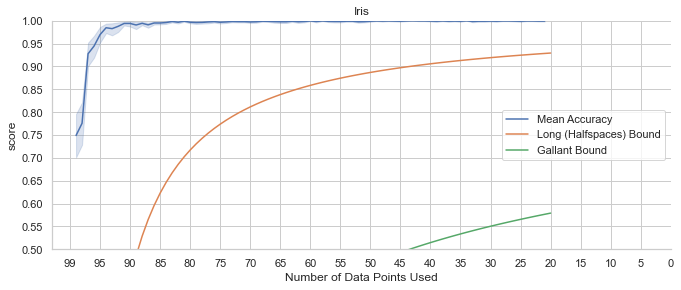

In [40]:
#sns.relplot(data=lin_and_pac, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)

ax = sns.relplot(data=iris_and_bounds, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)
plt.legend(loc='center right')
ax._legend.remove()
# Figure Attributes (using pyplot)
n_data = int(iris_pkl['n_data']/100) # Used for showing how many data points were used.

#plt.title('Score vs Buckets Used (Synthetic Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[99] + [percentage for percentage in range(95, -1, -5)]
)
scr_min, scr_max = 0.5, 1.
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
plt.xlabel("Number of Data Points Used")
#ax.set(title='Score vs Buckets Used')
plt.title("Iris")
ax.figure.savefig('iris_bounds.png', dpi=200)
#plt.show()

#### Skin/No Skin Dataset (Non-Linearly Separable)
<a id="skin-non-plot"></a>

In [187]:
# Plot Configuration
height = 4
aspect = 12/7

In [191]:
skin_data

{'score': [0.7433333333333333,
  0.7516666666666667,
  0.7883333333333333,
  0.765,
  0.7666666666666667,
  0.7866666666666666,
  0.7883333333333333,
  0.7483333333333333,
  0.20833333333333334,
  0.77,
  0.7783333333333333,
  0.7816666666666666,
  0.7816666666666666,
  0.7816666666666666,
  0.7866666666666666,
  0.7916666666666666,
  0.78,
  0.7916666666666666,
  0.7916666666666666,
  0.7716666666666666,
  0.755,
  0.775,
  0.7666666666666667,
  0.7716666666666666,
  0.7916666666666666,
  0.7916666666666666,
  0.20833333333333334,
  0.7916666666666666,
  0.76,
  0.7733333333333333,
  0.7916666666666666,
  0.77,
  0.7916666666666666,
  0.7916666666666666,
  0.7833333333333333,
  0.7916666666666666,
  0.7716666666666666,
  0.7633333333333333,
  0.7816666666666666,
  0.7816666666666666,
  0.7416666666666667,
  0.775,
  0.7616666666666667,
  0.7516666666666667,
  0.7566666666666667,
  0.7533333333333333,
  0.7866666666666666,
  0.7916666666666666,
  0.79,
  0.7916666666666666,
  0.78,
  0

In [214]:
temp = pd.DataFrame(skin_data)

In [229]:
temp.loc[temp['corruption']==0].score + 0.05

29304    0.841667
29305    0.841667
29306    0.841667
29307    0.841667
29308    0.841667
           ...   
29399    0.841667
29400    0.258333
29401    0.841667
29402    0.841667
29403    0.841667
Name: score, Length: 100, dtype: float64

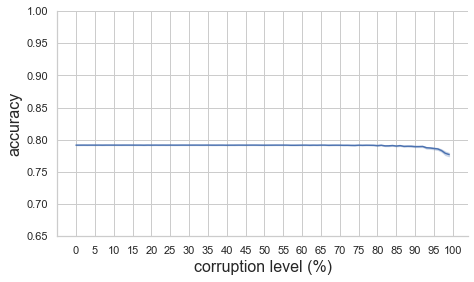

In [272]:
ax = sns.relplot(data=skin_data, kind='line', x='corruption', y='score', height=height, aspect=aspect)

# Figure Attributes (using pyplot)
#plt.title('Score vs Buckets Used (Skin Segmentation Dataset | Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[percentage for percentage in range(0, 101, 5)]
)
plt.xlabel("corruption level (%)", fontsize=16)
plt.ylabel('accuracy', fontsize=16)
scr_min, scr_max = 0.65, 1.
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 8))
ax.figure.savefig('img_results/skin_percent.png', dpi=200)
#plt.show()

In [48]:
ax = sns.relplot(data=skin_data, kind='line', x='corruption', y='score', height=height, aspect=aspect)

# Figure Attributes (using pyplot)
n_data = int(2500/100) # Used for showing how many data points were used.

#plt.title('Score vs Buckets Used (Skin Segmentation Dataset | Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[1*n_data] + [percentage*n_data for percentage in range(5, 101, 5)]
)
plt.yticks(np.linspace(0.6, 1., 11))
plt.xlabel("Number of Data Points Used")
#ax.set(title='Score vs Buckets Used')
ax.figure.savefig('img_results/skin_points.png', dpi=200)
#plt.show()

ValueError: Could not interpret value `buckets` for parameter `x`

##### PAC Bounds

In [184]:
'''PAC Bounds according to P.M. Long on Half-spaces'''
# Calculate Epsilon Lower Bounds
total_data    = 2_500 # skin_pkl['n_data']
total_buckets = skin_pkl['n_buckets']
vc_dim        = skin_pkl['n_attribs'] + 1 # Radon's Theorem
delta         = 0.01

epsilon_PAC = epsilon_PAC_complexity(total_data=total_data, total_buckets=total_buckets, vc_dim=vc_dim, delta=delta)
    
# Create matching data frame that could be concatenated with data to produce seaborn plot
epsilon_PAC = epsilon_PAC.assign(n_run=-1, dataset='Long (Halfspaces) Bound') 
epsilon_PAC['score'] = epsilon_PAC.score.map(lambda x: x if x > 0. else np.NaN) # Mask invalid (negative) values


'''Gallant Bounds on Pocket Perceptron'''
### Yhea, this takes long... () ###
# Dataset parameters
total_data    = 2_500 # skin_pkl['n_data']
total_buckets = skin_pkl['n_buckets']
# Calculating Error for e0
skin_dataframe= pd.DataFrame(history_skin).drop('L', axis=1)
epsilon_knot  = 1 - skin_dataframe.mean().mean()
#epsilon_knot  = #0.05
vc_dim        = skin_pkl['n_attribs'] + 1 # Radon's Theorem
delta         = 0.05
L             = pd.DataFrame(history_skin['L']).max().max()
# vc_dim = 10 # Gallant's paper comparison of results
epsilon_pocket = epsilon_pocket_complexity(total_data=total_data, total_buckets=total_buckets, epsilon_knot=epsilon_knot, delta=delta, vc_dim=vc_dim, L=L)
    
# Make data match results from experiments' parameters
epsilon_pocket = epsilon_pocket.assign(n_run=-1, dataset='Pocket Gallant Bound')
#epsilon_pocket = epsilon_pocket[lin_pocket_err.buckets < n_buckets] # Set limit of n samples. (Else, we get up to ~50,000)


# Creates new columns dataset to identify between scores from actual results and PAC analysis
pre_concat = [
    pd.DataFrame(skin_data).assign(dataset='Mean Accuracy'), 
    epsilon_PAC,
    epsilon_pocket
]

# Final data table
skin_and_bounds = pd.concat(pre_concat).reset_index(drop=True)




In [45]:
# Plot Configuration
height = 4
aspect = 12/6

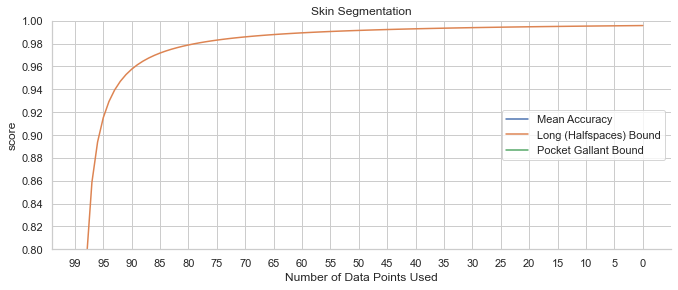

In [46]:
#sns.relplot(data=lin_and_pac, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)

ax = sns.relplot(data=skin_and_bounds, kind='line', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)
plt.legend(loc='center right')
ax._legend.remove()
# Figure Attributes (using pyplot)
# Actual # of datapoints used was 2,500!
n_data = int(2_500/100) # Used for showing how many data points were used.

#plt.title('Score vs Buckets Used (Synthetic Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[99] + [percentage for percentage in range(95, -1, -5)]
)
scr_min, scr_max = 0.8, 1.
plt.ylim(scr_min, scr_max)
plt.yticks(np.linspace(scr_min, scr_max, 11))
plt.xlabel("Number of Data Points Used")
plt.title("Skin Segmentation")
#ax.set(title='Score vs Buckets Used')
ax.figure.savefig('img_results/skin_bounds.png', dpi=200)
#plt.show()

## Combined Lines by Linear Separability

### Linear Datasets

In [42]:
linear_datas = {'score': [], 'buckets': [], 'n_run': [], 'dataset': []}
datas = {'Synthetic': history_lin, 'Real-World (iris)': history_iris}

for data_name, history_data in datas.items():
    for n_buckets, scores in history_data.items():
        if n_buckets == 'L':
            continue
        for n_run, score in enumerate(scores):
            linear_datas['score'].append(score)
            linear_datas['buckets'].append(n_buckets)
            linear_datas['n_run'].append(n_run)
            linear_datas['dataset'].append(data_name)


In [43]:
height = 8
aspect = 2

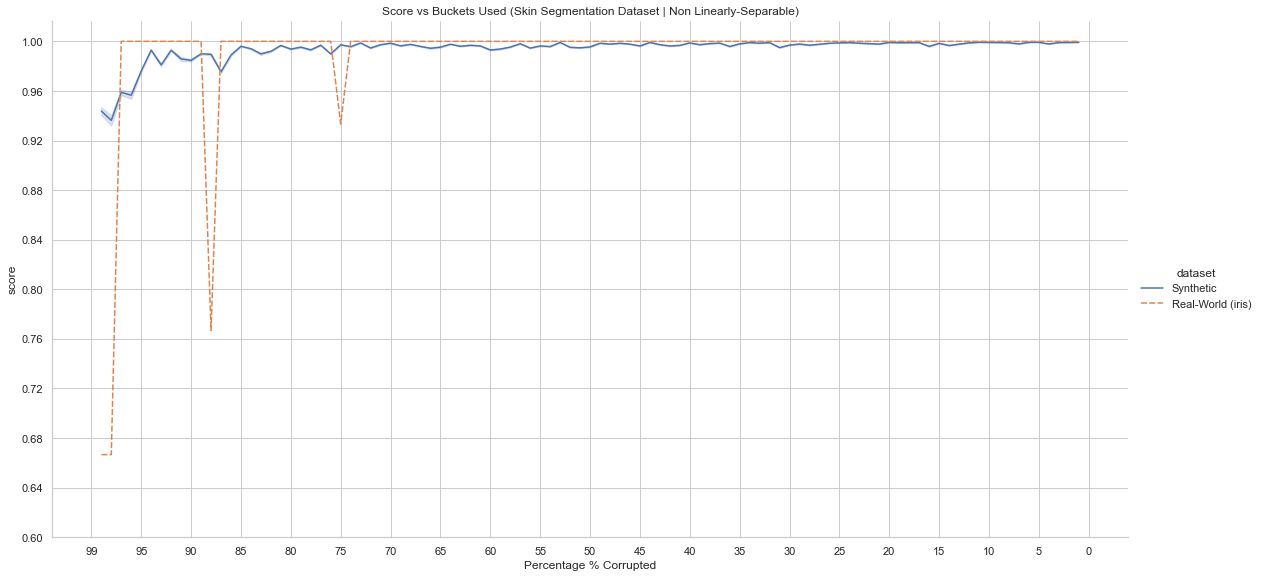

In [44]:
sns.relplot(data=linear_datas, kind='line', x='buckets', y='score', hue='dataset', style='dataset', height=height, aspect=aspect)
# Figure Attributes (using pyplot)
plt.title('Score vs Buckets Used (Skin Segmentation Dataset | Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[1] + [percentage for percentage in range(5, 101, 5)]
)
plt.xlabel("Percentage % Corrupted")
plt.yticks(np.linspace(0.6, 1., 11))

plt.show()

### Non-Linear Datasets

In [45]:
non_linear_datas = {'score': [], 'buckets': [], 'n_run': [], 'dataset': []}
datas = {'Synthetic': history_non_lin, 'Real-World (Skin/No Skin)': history_skin}

for data_name, history_data in datas.items():
    for n_buckets, scores in history_data.items():
        if n_buckets == 'L':
            continue
        for n_run, score in enumerate(scores):
            non_linear_datas['score'].append(score)
            non_linear_datas['buckets'].append(n_buckets)
            non_linear_datas['n_run'].append(n_run)
            non_linear_datas['dataset'].append(data_name)


In [46]:
height = 8
aspect = 2

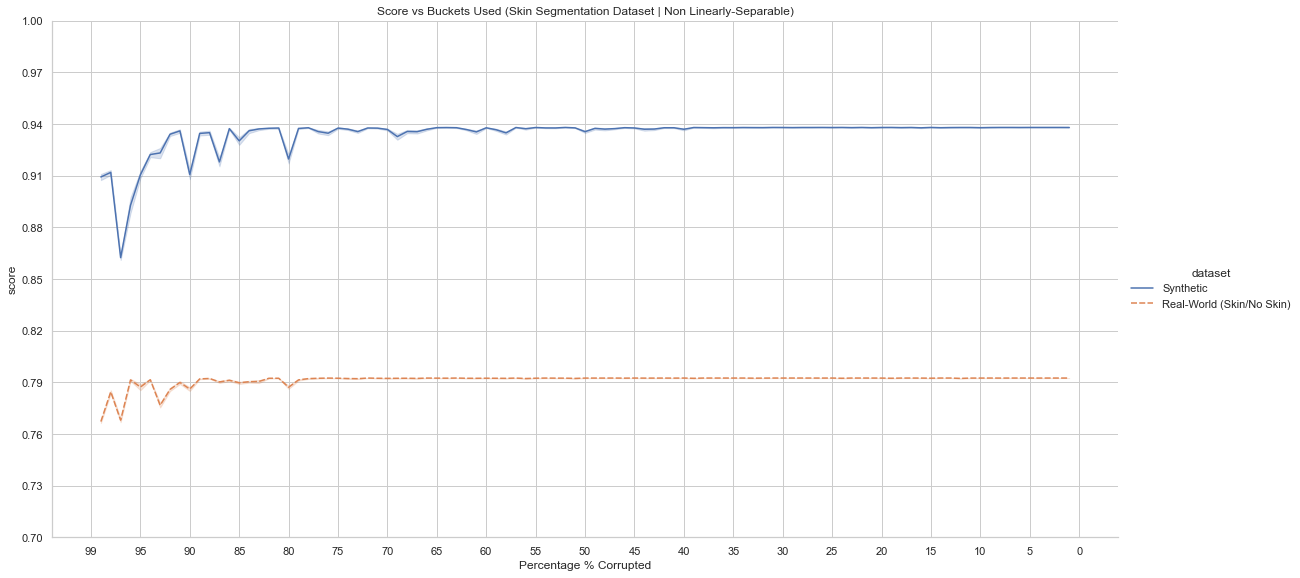

In [47]:
sns.relplot(data=non_linear_datas, kind='line', x='buckets', y='score', hue='dataset', style='dataset', height=height, aspect=aspect)
# Figure Attributes (using pyplot)
plt.title('Score vs Buckets Used (Skin Segmentation Dataset | Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[1] + [percentage for percentage in range(5, 101, 5)]
)
plt.xlabel("Percentage % Corrupted")
plt.yticks(np.linspace(0.7, 1., 11))

plt.show()

## Box Plots

In [11]:
height = 4
aspect = 12/7
PROPS = {
    'boxprops':{'facecolor':'whitesmoke', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops': {'color': 'green'}
}

### Synthetic Datasets

#### Linearly-Separable
<a id="syn-lin-box"></a>

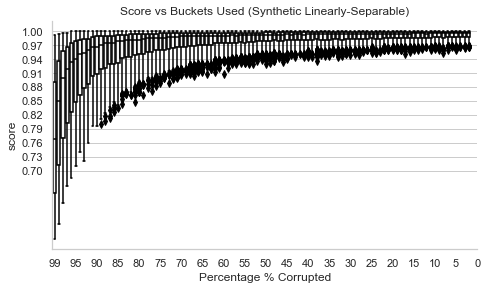

In [25]:
'''
PROPS = {
    'boxprops':{'facecolor':'whitesmoke', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops': {'color': 'green'}
}
'''

ax = sns.catplot(data=pd.DataFrame(lin_data), kind='box', x='buckets', y='score', height=height, aspect=aspect, color='black', **PROPS)

# Figure Attributes (using pyplot)
plt.title('Score vs Amount of Corrupted Data')plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[99] + [percentage for percentage in range(95, -1, -5)]
)
plt.xlabel("Percentage % Corrupted")
plt.yticks(np.linspace(0.7, 1., 11))
ax.figure.savefig('lin_box.png', dpi=200)

#plt.show()

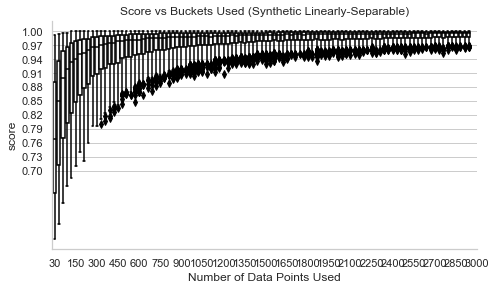

In [26]:
ax = sns.catplot(data=pd.DataFrame(lin_data), kind='box', x='buckets', y='score', height=height, aspect=aspect, color='black', **PROPS)

# Figure Attributes (using pyplot)
n_data = int(lin_pkl['n_data']/100) # Used for showing how many data points were used.

plt.title('Score vs Buckets Used (Synthetic Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[1*n_data] + [percentage*n_data for percentage in range(5, 101, 5)]
)
plt.yticks(np.linspace(0.7, 1., 11))
plt.xlabel("Number of Data Points Used")
#ax.set(title='Score vs Buckets Used')
plt.show()

#### Non-Linearly Separable
<a id="syn-non-box"></a>

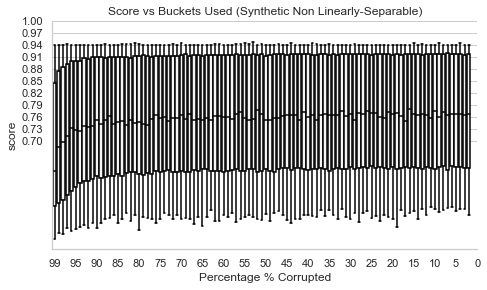

In [27]:
ax = sns.catplot(data=pd.DataFrame(non_lin_data), kind='box', x='buckets', y='score', height=height, aspect=aspect, color='black', **PROPS, saturation=0.1)
# Figure Attributes (using pyplot)
plt.title('Score vs Buckets Used (Synthetic Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[99] + [percentage for percentage in range(95, -1, -5)]
)
plt.xlabel("Percentage % Corrupted")
plt.yticks(np.linspace(0.7, 1., 11))

ax.figure.savefig('non_box.png', dpi=200)

#plt.show()

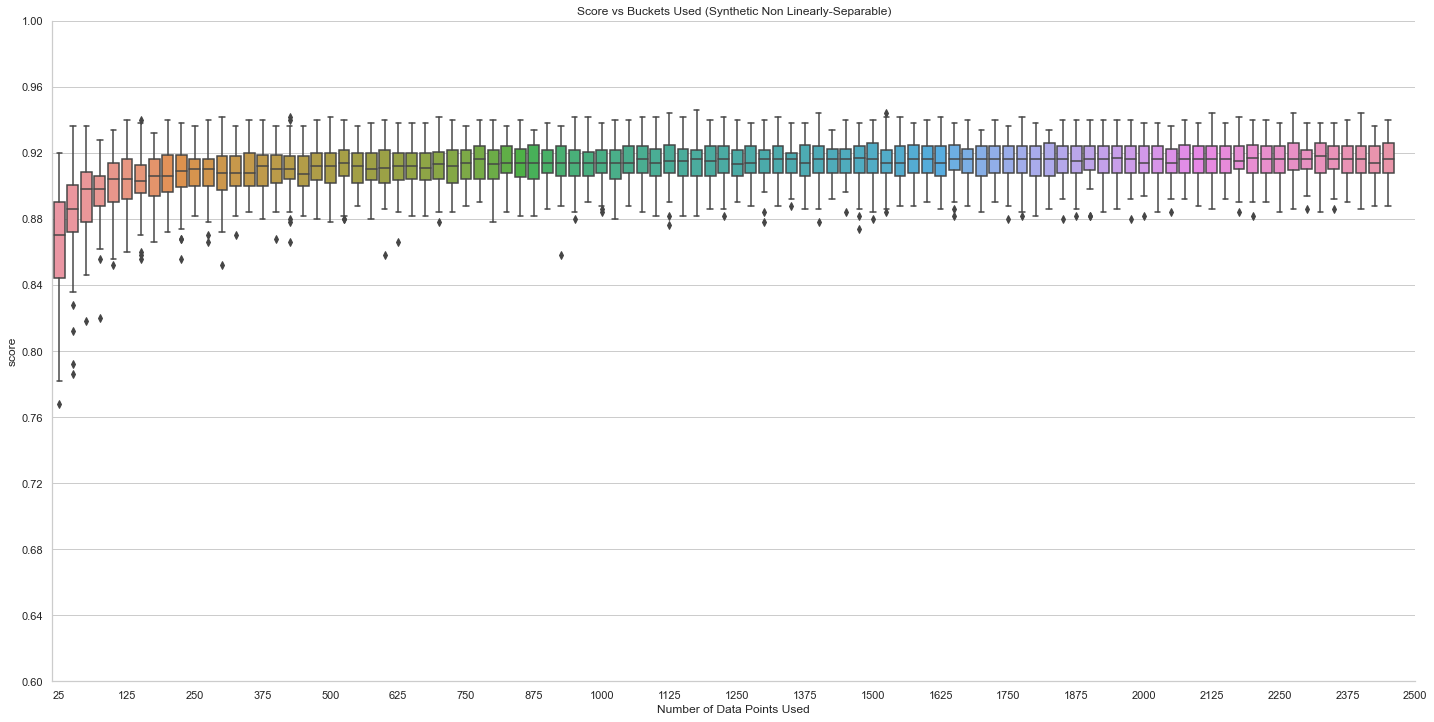

In [70]:
ax = sns.catplot(data=pd.DataFrame(non_lin_data), kind='box', x='buckets', y='score', height=height, aspect=aspect)

# Figure Attributes (using pyplot)
n_data = int(non_lin_pkl['n_data']/100) # Used for showing how many data points were used.

plt.title('Score vs Buckets Used (Synthetic Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[1*n_data] + [percentage*n_data for percentage in range(5, 101, 5)]
)
plt.yticks(np.linspace(0.6, 1., 11))
plt.xlabel("Number of Data Points Used")
#ax.set(title='Score vs Buckets Used')
plt.show()

### Real Datasets

#### Iris Dataset
<a id="iris-lin-box"></a>

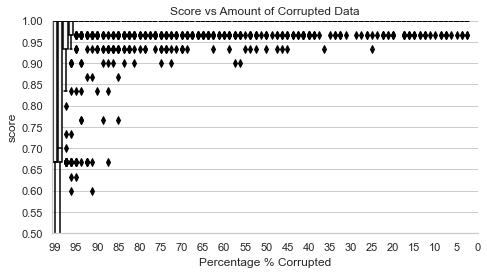

In [12]:
ax = sns.catplot(data=pd.DataFrame(iris_data), kind='box', x='buckets', y='score', height=height, aspect=aspect, color='black', **PROPS, saturation=0.1)
# Figure Attributes (using pyplot)
ax.fig.subplots_adjust(top=0.9)

plt.title('Score vs Amount of Corrupted Data')
plt.xticks(
    ticks=range(0, 81, 4), 
    labels=[99] + [percentage for percentage in range(95, -1, -5)]
)
plt.xlabel("Percentage % Corrupted")
plt.yticks(np.linspace(0.5, 1., 11))
plt.ylim(0.5, 1.)
ax.figure.savefig('img_results/iris_box.png', dpi=200)


#plt.show()

In [10]:
sns.catplot(data=pd.DataFrame(iris_data), kind='box', x='buckets', y='score', height=height, aspect=aspect, color='black', **PROPS, saturation=0.1)
# Figure Attributes (using pyplot)
n_data = int(iris_pkl['n_data']/100) # Used for showing how many data points were used.

plt.title('Score vs Buckets Used (Iris Dataset | Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[1*n_data] + [percentage*n_data for percentage in range(5, 101, 5)]
)
plt.yticks(np.linspace(0.5, 1., 11))
plt.ylim(0.5, 1.)

plt.xlabel("Number of Data Points Used")
#ax.set(title='Score vs Buckets Used')
plt.show()

NameError: name 'PROPS' is not defined

#### Skin/No Skin Dataset
<a id="skin-non-box"></a>

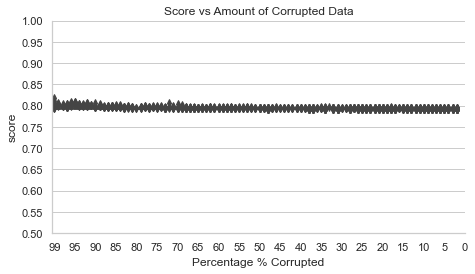

In [13]:
ax = sns.catplot(data=pd.DataFrame(skin_data), kind='box', x='buckets', y='score', height=height, aspect=aspect)
# Figure Attributes (using pyplot)
ax.fig.subplots_adjust(top=0.9)

plt.title('Score vs Amount of Corrupted Data')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[99] + [percentage for percentage in range(95, -1, -5)]
)
plt.xlabel("Percentage % Corrupted")
plt.yticks(np.linspace(0.5, 1., 11))
ax.figure.savefig('img_results/skin_box.png', dpi=200)

#plt.show()

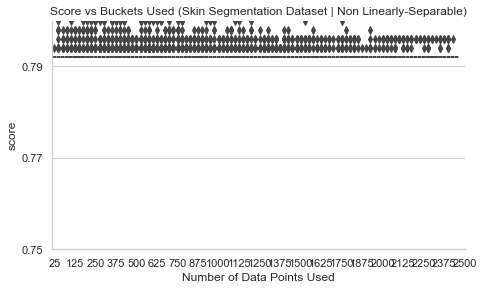

In [22]:
ax = sns.catplot(data=pd.DataFrame(skin_data), kind='box', x='buckets', y='score', height=height, aspect=aspect)
# Figure Attributes (using pyplot)
n_data = int(skin_pkl['n_data']/100) # Used for showing how many data points were used.

plt.title('Score vs Buckets Used (Skin Segmentation Dataset | Non Linearly-Separable)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[1*n_data] + [percentage*n_data for percentage in range(5, 101, 5)]
)
plt.yticks(np.linspace(0.65, 0.85, 11))
plt.ylim(0.75, 0.8)
plt.xlabel("Number of Data Points Used")
#ax.set(title='Score vs Buckets Used')
plt.show()

### Values with respect to type

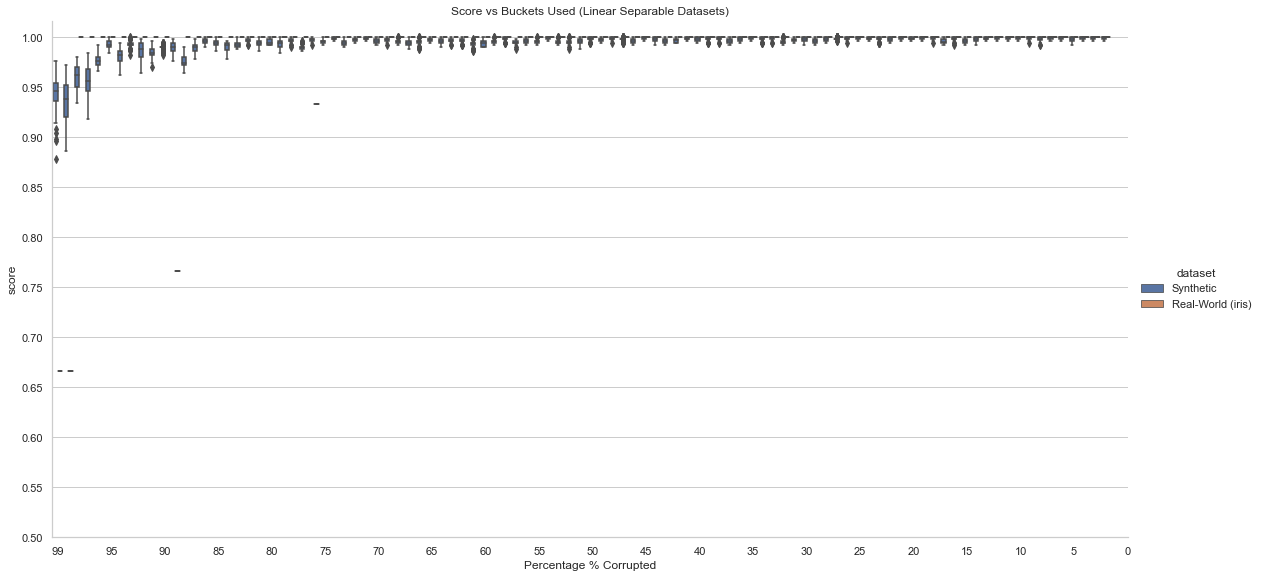

In [48]:
sns.catplot(data=pd.DataFrame(linear_datas), kind='box', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)

# Figure Attributes (using pyplot)
plt.title('Score vs Buckets Used (Linear Separable Datasets)')
plt.xticks(
    ticks=range(0, 101, 5), 
    labels=[99] + [percentage for percentage in range(95, -1, -5)]
)
plt.xlabel("Percentage % Corrupted")
plt.yticks(np.linspace(0.5, 1., 11))

plt.show()

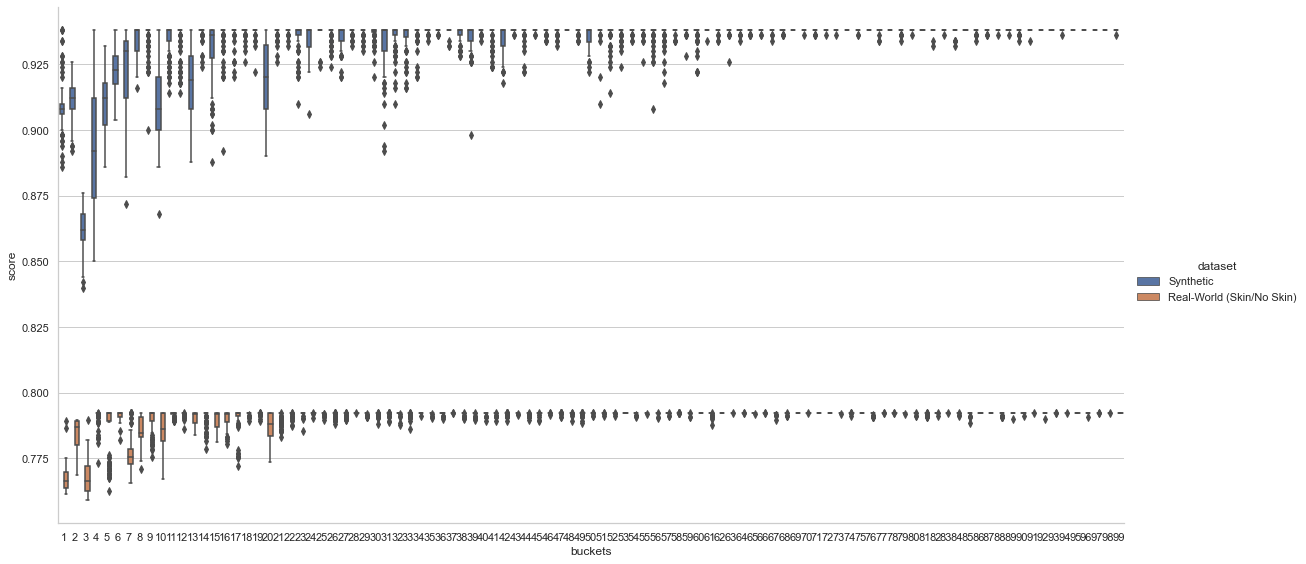

In [49]:
sns.catplot(data=pd.DataFrame(non_linear_datas), kind='box', x='buckets', y='score', hue='dataset', height=height, aspect=aspect)

# Table

In [134]:
percents = [1, 2, 3, 4, 5, 10, 15, 20]
percentages = 99 - np.array(percents) 

### Synthetic Datasets

#### Linearly Separable
<a id="syn-lin-table"></a>

In [135]:
lin_dataframe = pd.DataFrame(history_lin)

In [136]:
# Mean
lin_mean = pd.DataFrame(lin_dataframe.mean())
lin_mean = lin_mean.iloc[percentages]
lin_mean = lin_mean.rename(columns={0: 'Mean Expected Error'})
lin_mean['Percentage of Data Corruption'] = percents
lin_mean

/tmp/ipykernel_20378/2479751039.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  lin_mean = pd.DataFrame(lin_dataframe.mean())


,Mean Expected Error,Percentage of Data Corruption
99,0.99868,1
98,0.99840,2
97,0.99834,3
96,0.99838,4
95,0.99838,5
90,0.99844,10
85,0.99810,15
80,0.99820,20


In [137]:
# Worst
lin_worst = pd.DataFrame(lin_dataframe.min())
lin_worst = lin_worst.iloc[percentages]
lin_worst = lin_worst.rename(columns={0: 'Mean Expected Error'})
lin_worst['Percentage of Data Corruption'] = percents
lin_worst

,Mean Expected Error,Percentage of Data Corruption
99,0.99,1
98,0.99,2
97,0.99,3
96,0.99,4
95,0.99,5
90,0.992,10
85,0.99,15
80,0.99,20


#### Non-Linearly Separable
<a id="syn-non-table"></a>

In [138]:
non_lin_dataframe = pd.DataFrame(history_non_lin)

In [139]:
# Mean
non_lin_mean = pd.DataFrame(non_lin_dataframe.mean())
non_lin_mean = non_lin_mean.iloc[percentages]
non_lin_mean = non_lin_mean.rename(columns={0: 'Mean Expected Error'})
non_lin_mean['Percentage of Data Corruption'] = percents
non_lin_mean

/tmp/ipykernel_20378/2959504492.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  non_lin_mean = pd.DataFrame(non_lin_dataframe.mean())


,Mean Expected Error,Percentage of Data Corruption
99,0.91664,1
98,0.91514,2
97,0.91664,3
96,0.91676,4
95,0.91628,5
90,0.91624,10
85,0.91594,15
80,0.91582,20


In [140]:
# Worst
non_lin_worst = pd.DataFrame(non_lin_dataframe.min())
non_lin_worst = non_lin_worst.iloc[percentages]
non_lin_worst = non_lin_worst.rename(columns={0: 'Mean Expected Error'})
non_lin_worst['Percentage of Data Corruption'] = percents
non_lin_worst

,Mean Expected Error,Percentage of Data Corruption
99,0.888,1
98,0.888,2
97,0.886,3
96,0.89,4
95,0.886,5
90,0.89,10
85,0.888,15
80,0.88,20


### Real Datasets

#### Iris Dataset
<a id="iris-lin-table"></a>

In [149]:
iris_dataframe = pd.DataFrame(history_iris)

In [151]:
pd.DataFrame(iris_dataframe.mean())

/tmp/ipykernel_20378/2795968930.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.DataFrame(iris_dataframe.mean())


,0
1,0.749000
2,0.775667
3,0.927667
4,0.944667
5,0.969667
...,...
75,0.999000
76,0.999667
77,0.999667
78,0.999333


In [152]:
# Mean
iris_mean = pd.DataFrame(iris_dataframe.mean())
iris_mean = iris_mean.iloc[percentages - 20]
iris_mean = iris_mean.rename(columns={ 0: 'Mean Expected Error'})
iris_mean['Percentage of Data Corruption'] = percents
iris_mean

/tmp/ipykernel_20378/1446186550.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  iris_mean = pd.DataFrame(iris_dataframe.mean())


,Mean Expected Error,Percentage of Data Corruption
79,0.999333,1
78,0.999333,2
77,0.999667,3
76,0.999667,4
75,0.999000,5
70,0.999333,10
65,0.999000,15
60,0.999333,20


In [154]:
# Worst
iris_worst = pd.DataFrame(iris_dataframe.min())
iris_worst = iris_worst.iloc[percentages-20]
iris_worst = iris_worst.rename(columns={0: 'Mean Expected Error'})
iris_worst['Percentage of Data Corruption'] = percents
iris_worst

,Mean Expected Error,Percentage of Data Corruption
79,0.966667,1
78,0.966667,2
77,0.966667,3
76,0.966667,4
75,0.966667,5
70,0.966667,10
65,0.966667,15
60,0.966667,20


#### Skin/No Skin Dataset
<a id="skin-non-table"></a>

In [60]:
skin_dataframe = pd.DataFrame(history_skin)

In [61]:
# Mean
skin_mean = pd.DataFrame(skin_dataframe.mean())
skin_mean = skin_mean.iloc[percentages]
skin_mean = skin_mean.rename(columns={0: 'Mean Expected Error'})
skin_mean['Percentage of Data Corruption'] = percents
skin_mean

/tmp/ipykernel_19898/4068991068.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skin_mean = pd.DataFrame(skin_dataframe.mean())


,Mean Expected Error,Percentage of Data Corruption
99,0.792459,1
98,0.792458,2
97,0.792458,3
96,0.792442,4
95,0.792459,5
90,0.792446,10
85,0.792375,15
80,0.792435,20


In [62]:
# Worst
skin_worst = pd.DataFrame(skin_dataframe.min())
skin_worst = skin_worst.iloc[percentages]
skin_worst = skin_worst.rename(columns={0: 'Mean Expected Error'})
skin_worst['Percentage of Data Corruption'] = percents
skin_worst

,Mean Expected Error,Percentage of Data Corruption
99,0.792459,1
98,0.792398,2
97,0.792398,3
96,0.790745,4
95,0.792459,5
90,0.791112,10
85,0.788623,15
80,0.791296,20
